https://hudsonthames.org/an-introduction-to-the-hierarchical-risk-parity-algorithm/

# Correlation matrix, Distance matrix

In [127]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
%matplotlib inline

# Define the tickers and initial weights
tickers = ['TSLA', 'BABA', 'META', 'JPM','PLTR','SNOW','SHOP','COIN','SOXL','FNGU','CCL','CMG','FUBO','NIO','LMT','BG','NVDA']

# Fetch historical price data
data = yf.download(tickers, period='3y', auto_adjust=True)['Close']

# Calculate daily log returns
returns = np.log(data / data.shift(1)).dropna()

# Calculate covariance matrix
cov = returns.cov()
corr = returns.corr(method='pearson')
distances = np.sqrt((1 - corr) / 2)

[*********************100%***********************]  17 of 17 completed


In [128]:
stocklist = cov.index
cov = cov.reset_index(drop = True)
cov.columns = cov.index
returns.columns = cov.index

# Matrix Seriation - quasi-diagonalization

https://gmarti.gitlab.io/ml/2017/09/07/how-to-sort-distance-matrix.html

In [103]:
def seriation(Z, N, cur_index):
    """Returns the order implied by a hierarchical tree (dendrogram).
    
       :param Z: A hierarchical tree (dendrogram).
       :param N: The number of points given to the clustering process.
       :param cur_index: The position in the tree for the recursive traversal.
       
       :return: The order implied by the hierarchical tree Z.
    """
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index - N, 0])
        right = int(Z[cur_index - N, 1])
        return (seriation(Z, N, left) + seriation(Z, N, right))
    
def compute_serial_matrix(dist_mat, method="ward"):
    """Returns a sorted distance matrix.
    
       :param dist_mat: A distance matrix.
       :param method: A string in ["ward", "single", "average", "complete"].
        
        output:
            - seriated_dist is the input dist_mat,
              but with re-ordered rows and columns
              according to the seriation, i.e. the
              order implied by the hierarchical tree
            - res_order is the order implied by
              the hierarhical tree
            - res_linkage is the hierarhical tree (dendrogram)
        
        compute_serial_matrix transforms a distance matrix into 
        a sorted distance matrix according to the order implied 
        by the hierarchical tree (dendrogram)
    """
    N = len(dist_mat)
    flat_dist_mat = squareform(dist_mat)
    res_linkage = linkage(flat_dist_mat, method=method)
    res_order = seriation(res_linkage, N, N + N - 2)
    seriated_dist = np.zeros((N, N))
    a,b = np.triu_indices(N, k=1)
    seriated_dist[a,b] = dist_mat[[res_order[i] for i in a], [res_order[j] for j in b]]
    seriated_dist[b,a] = seriated_dist[a,b]
    
    return seriated_dist, res_order, res_linkage

In [104]:
ordered_dist_mat, res_order, res_linkage = compute_serial_matrix(distances.values, method='single')

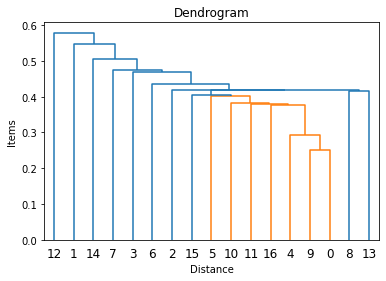

In [105]:
dendrogram(res_linkage, labels = res_order)
plt.xlabel('Distance')
plt.ylabel('Items')
plt.title('Dendrogram')
plt.show()

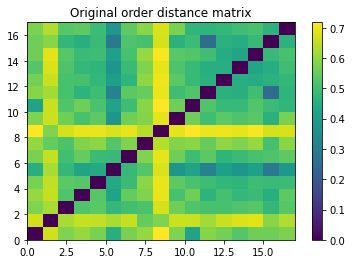

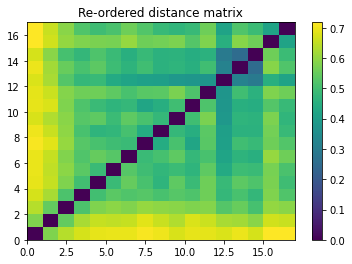

In [106]:
plt.pcolormesh(distances)
plt.colorbar()
plt.title('Original order distance matrix')
plt.show()

plt.pcolormesh(ordered_dist_mat)
plt.colorbar()
plt.title('Re-ordered distance matrix')
plt.show()

# Lopez de Prado’s recursive bisection

In [107]:
def compute_HRP_weights(covariances, res_order):
    weights = pd.Series(1, index=res_order)
    clustered_items = [res_order]

    while len(clustered_items) > 0:
        clustered_items = [cluster[start:end] for cluster in clustered_items for start, end in ((0, len(cluster) // 2),(len(cluster) // 2, len(cluster))) if len(cluster) > 1]
        for subcluster in range(0, len(clustered_items), 2): #parse in pairs
            left_cluster = clustered_items[subcluster]
            right_cluster = clustered_items[subcluster + 1]

            left_subcovar = covariances.loc[left_cluster, left_cluster]
            inv_diag = 1 / np.diag(left_subcovar.values)
            parity_w = inv_diag * (1 / np.sum(inv_diag))
            left_cluster_var = np.dot(parity_w, np.dot(left_subcovar, parity_w))

            right_subcovar = covariances.loc[right_cluster, right_cluster]
            inv_diag = 1 / np.diag(right_subcovar.values)
            parity_w = inv_diag * (1 / np.sum(inv_diag))
            right_cluster_var = np.dot(parity_w, np.dot(right_subcovar, parity_w))

            alloc_factor = 1 - left_cluster_var / (left_cluster_var + right_cluster_var)
            weights[left_cluster] *= alloc_factor
            weights[right_cluster] *= 1 - alloc_factor
            
    return weights

In [131]:
HRP_weights = compute_HRP_weights(cov, res_order)
HRP_weights = HRP_weights.sort_index()
HRP_weights.index = stocklist

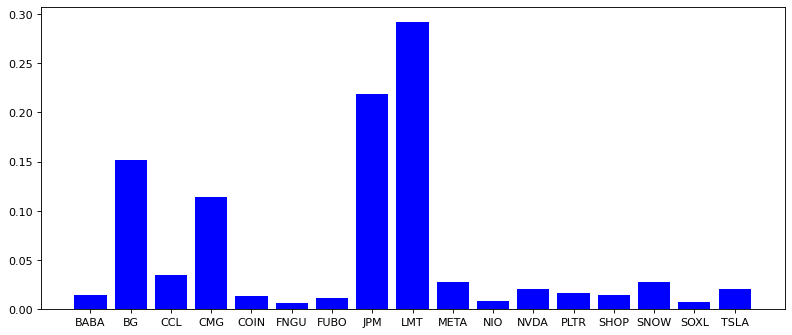

In [150]:
plt.figure(figsize=(12, 5), dpi= 80)
plt.bar(HRP_weights.index,HRP_weights.values, color ='blue')

plt.show()

In [116]:
r = (HRP_weights * returns).sum(axis=1).mean() * 252

0.044366338350498795

In [117]:
std = (HRP_weights * returns).sum(axis=1).std() * np.sqrt(252)

0.215370598080574